In [1]:
#import the required modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import time

from deepface import DeepFace

file_path = "C:/Users/erdem/Downloads/celebA/images/"

## Looking at the Male Distribution

<a href="https://www.kaggle.com/datasets/jessicali9530/celeba-dataset">Dataset</a>

In [2]:
attributes = pd.read_csv("C:/Users/erdem/Downloads/celebA/list_attr_celeba.csv")

In [3]:
attributes.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
attributes[["Male"]].describe()

,Male
count,202599.000000
mean,-0.166491
std,0.986045
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,1.000000
max,1.000000


In [5]:
attributes[["Male"]].value_counts()

Male
-1      118165
 1       84434
Name: count, dtype: int64

In [6]:
is_male = attributes[["image_id", "Male"]]
is_male.head()

,image_id,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [7]:
is_male.Male = is_male.Male.map({1:"Man",-1:"Woman"})

In [8]:
is_male.head()

,image_id,Male
0,000001.jpg,Woman
1,000002.jpg,Woman
2,000003.jpg,Man
3,000004.jpg,Woman
4,000005.jpg,Woman


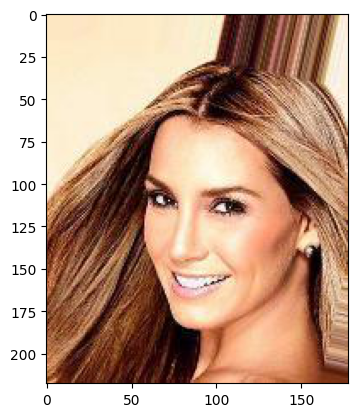

Action: gender: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


{'gender': {'Woman': 99.99998807907104, 'Man': 8.537791273965922e-06},
 'dominant_gender': 'Woman',
 'region': {'x': 40, 'y': 74, 'w': 98, 'h': 98}}

In [9]:
# read image
img = plt.imread(f"{file_path}000001.jpg")
  
# call imshow() using plt object
plt.imshow(img)

# display that image
plt.show()

# storing the result
result = DeepFace.analyze(img,
                          actions = ['gender'])
  
# print result
result[0]

In [10]:
samples = is_male[is_male.Male=="Woman"].sample(5)
samples

,image_id,Male
177606,177607.jpg,Woman
50936,050937.jpg,Woman
64927,064928.jpg,Woman
136195,136196.jpg,Woman
141977,141978.jpg,Woman


In [11]:
samples.iloc[0]

image_id    177607.jpg
Male             Woman
Name: 177606, dtype: object

In [12]:
def visualize(df):
    
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 4), dpi=100)
    
    man_samples = df[df.Male=="Man"].sample(4)
    woman_samples = df[df.Male=="Woman"].sample(4)
    
    for i in range(4):
        man_id = man_samples.iloc[i].image_id
        gender = man_samples.iloc[i].Male
        img = plt.imread(f"{file_path}{man_id}")
        
        ax[0,i].set_title(gender)
        ax[0,i].imshow(img)
        
    for i in range(4):
        woman_id = woman_samples.iloc[i].image_id
        gender = woman_samples.iloc[i].Male
        img = plt.imread(f"{file_path}{woman_id}")
        
        ax[1,i].set_title(gender)
        ax[1,i].imshow(img)
        
    plt.tight_layout()
    

def read_data():
    
    return [f for f in listdir(file_path) if isfile(join(file_path, f))]
    

def analyze_deepface(df, images, detector, short=False, cut=1000):
    
    n_img = len(images)
    results = []

    for idx, image in enumerate(images):
        img = plt.imread(f"{file_path}{image}")

        # storing the result
        result = DeepFace.analyze(img, actions = ['gender'], detector_backend=detector,
                                  enforce_detection=False, silent=True)
        results.append(result[0]["dominant_gender"])
        
        if idx%100 == 0:
            if short:
                print(f"progress: {idx}/{cut}")
            else:
                print(f"progress: {idx}/{n_img}")
            
        if short and idx == (cut-1):
            break

    return results


def accuracy(df, pred):
    
    n = len(pred)
    correct = 0
    
    
    for idx, p in enumerate(pred):
        
        if df.iloc[idx].Male == p:
            correct += 1
            
    
    return correct / n

def report(labels, preds):

    cm = confusion_matrix(labels,preds)
 
    # Plot the confusion matrix.
    plt.figure(figsize=(6,5), dpi=120)
    sns.heatmap(cm, annot=True,
                xticklabels=["Man","Woman"],
                yticklabels=["Man","Woman"], fmt="g", cmap="Blues", annot_kws={"size":25})

    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")

    print(classification_report(labels, preds))
    plt.show()

## Samples from the dataset

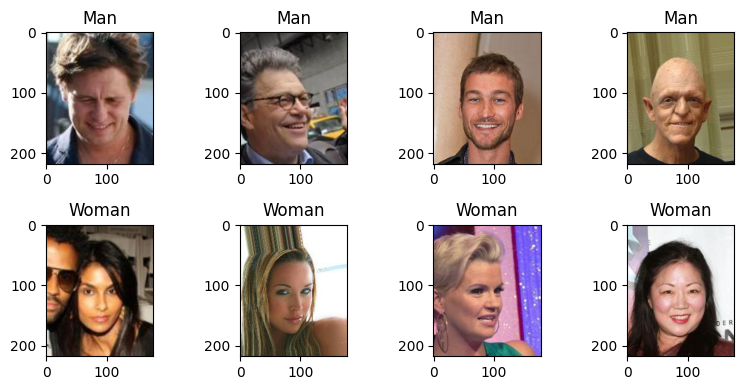

In [13]:
visualize(is_male)

## Testing with three different face detectors

In [14]:
detectors = ["opencv", "mtcnn", "mediapipe"]
cut = 1000

images = read_data()
labels = is_male.Male.values[:cut].tolist()

deepface_preds = {}
deepface_scores = {}
detector_times = {}

for detector in detectors:
    print(f"\n{detector} started!\n".upper())
    
    start = time.time()
    
    preds = analyze_deepface(is_male, images, detector, short=True, cut=cut)
    
    detector_times[detector] = time.time() - start
    
    deepface_preds[detector] = preds
    deepface_scores[detector] = accuracy(is_male, preds)
    
    


OPENCV STARTED!

progress: 0/1000
progress: 100/1000
progress: 200/1000
progress: 300/1000
progress: 400/1000
progress: 500/1000
progress: 600/1000
progress: 700/1000
progress: 800/1000
progress: 900/1000

MTCNN STARTED!

1/1 [==============================] - 0s 109ms/step
progress: 0/1000
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 3ms/step
progress: 100/1000
1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
progress: 200/1000
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
progress: 300/1000
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
progress: 400/1000
1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 21ms/step
progress: 500/1000
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
progress: 600/1000
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 46ms/step
progress: 700/1000
1/1 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 1000us/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 31ms/step
progress: 800/1000
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 17ms/step
progress: 900/1000
1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step

MEDIAPIPE STARTED!

progress: 0/1000
progress: 100/1000
progress: 200/1000
progress: 300/1000
progress: 400/1000
progress: 500/1000
progress: 600/1000
progress: 700/1000
progress: 800/1000
progress: 900/1000


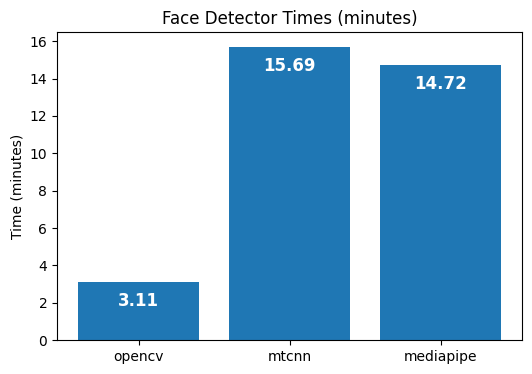

In [15]:
plt.figure(figsize=(6,4))

minutes = [s/60 for s in detector_times.values()]

plt.bar(detector_times.keys(), minutes)

plt.title("Face Detector Times (minutes)")
plt.ylabel("Time (minutes)")

for idx, value in enumerate(minutes):
    plt.text(idx, value-1, f"{value:.2f}", ha="center", va="center", fontsize="large", weight="bold", color="white")

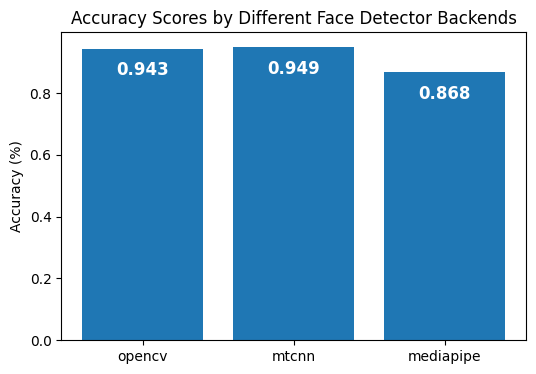

In [16]:
plt.figure(figsize=(6,4))

plt.bar(deepface_scores.keys(), deepface_scores.values())

plt.title("Accuracy Scores by Different Face Detector Backends")
plt.ylabel("Accuracy (%)")

for idx, value in enumerate(deepface_scores.values()):
    plt.text(idx, value-0.07, f"{value}", ha="center", va="center", fontsize="large",weight="bold", color="white")

              precision    recall  f1-score   support

         Man       0.88      1.00      0.94       432
       Woman       1.00      0.90      0.95       568

    accuracy                           0.94      1000
   macro avg       0.94      0.95      0.94      1000
weighted avg       0.95      0.94      0.94      1000



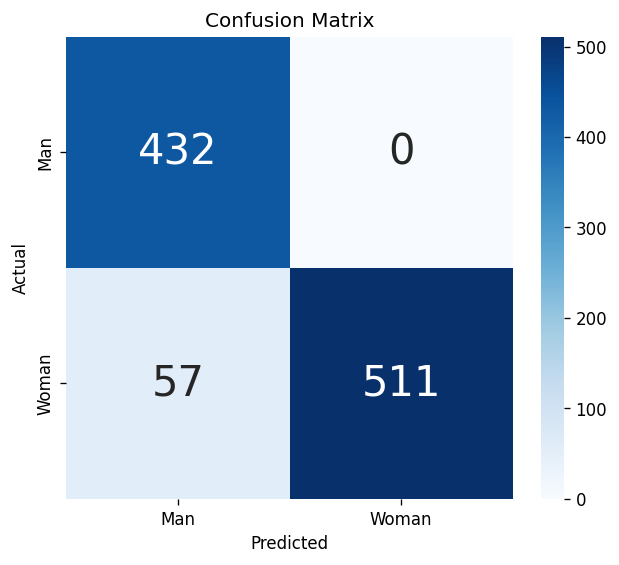

In [17]:
report(labels, deepface_preds["opencv"])

              precision    recall  f1-score   support

         Man       0.90      1.00      0.94       432
       Woman       1.00      0.91      0.95       568

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



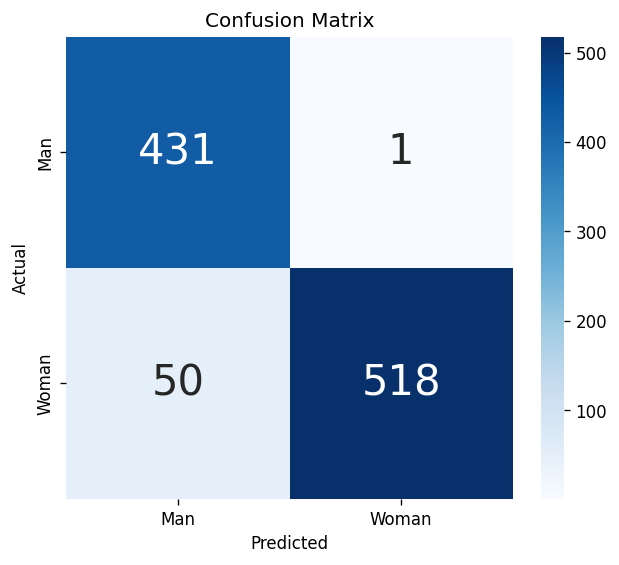

In [18]:
report(labels, deepface_preds["mtcnn"])

              precision    recall  f1-score   support

         Man       0.77      1.00      0.87       432
       Woman       1.00      0.77      0.87       568

    accuracy                           0.87      1000
   macro avg       0.88      0.88      0.87      1000
weighted avg       0.90      0.87      0.87      1000



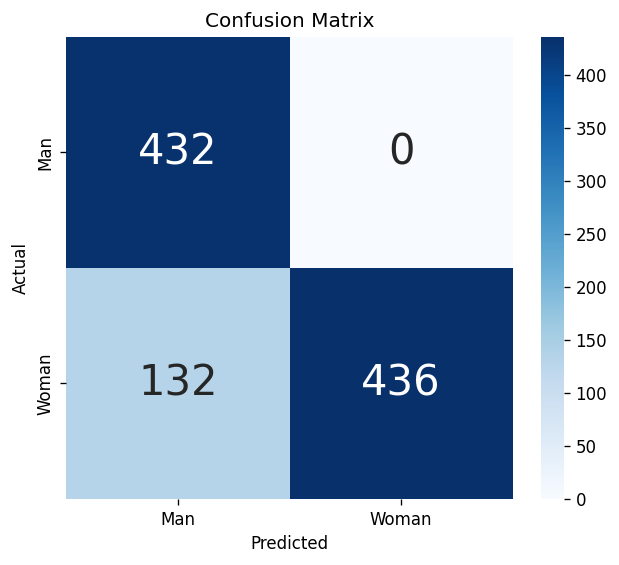

In [19]:
report(labels, deepface_preds["mediapipe"])